In [2]:
import pandas as pd
import os
import cv2
import yaml
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch

In [3]:
train_dirs = '../input/german-traffic-sign-detection-dataset/gtsdb/train'
test_dirs = '../input/german-traffic-sign-detection-dataset/gtsdb/test'
imgs_list = list(sorted(os.listdir(train_dirs)))


In [4]:
df = pd.read_csv('../input/german-traffic-sign-detection-dataset/gtsdb/train.csv')
df.head()

,image_id,leftCol,topRow,rightCol,bottomRow,class_id
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


In [5]:
img_list =[]
for idx in range(df.shape[0]):
    basename = os.path.basename(df['image_id'].iloc[idx])[:-4]
    img_list.append(basename + '.jpg')

In [6]:
df['image_id'] = list(img_list)

In [7]:
df['new'] = df.groupby('image_id')['image_id'].transform('count')

In [8]:
df1 = df.sort_values(['new','image_id'], ascending=[False, True]).drop('new', axis=1)

In [9]:
df1.head(10)

,image_id,leftCol,topRow,rightCol,bottomRow,class_id
107,00073.jpg,723,431,752,457,23
108,00073.jpg,727,457,748,477,2
109,00073.jpg,727,476,749,497,9
110,00073.jpg,425,428,456,455,23
111,00073.jpg,430,453,452,475,2
112,00073.jpg,432,475,452,495,9
325,00206.jpg,61,105,135,178,34
326,00206.jpg,1159,197,1224,261,33
327,00206.jpg,827,471,847,493,38
328,00206.jpg,55,8,164,103,13


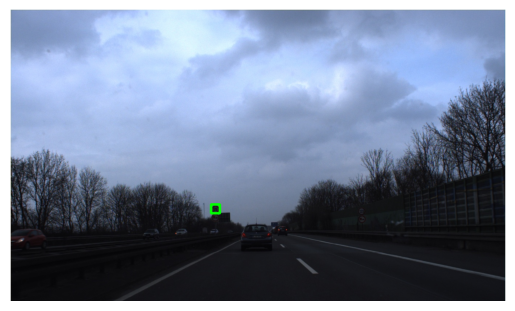

In [10]:
row = df1.iloc[70]
ymin = row.topRow
xmin = row.leftCol
ymax = row.bottomRow
xmax = row.rightCol
path = row.image_id
im = cv2.imread('../input/german-traffic-sign-detection-dataset/gtsdb/train/' + path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2.rectangle(im,(xmin,ymin),(xmax,ymax),(0,255,0),5)
plt.imshow(im)
plt.axis('off')
plt.show()

In [11]:
df1.rename(columns = {'image_id': 'img_name','leftCol': 'xmin', 'topRow': 'ymin', 
                      'rightCol': 'xmax', 'bottomRow': 'ymax', 'class_id': 'class'}, inplace = True)

In [12]:
width = 1360
height = 800

In [13]:
df1['x_centre'] = (df1['xmin'] + df1['xmax'])/2
df1['y_centre'] = (df1['ymin'] + df1['ymax'])/2
df1['width'] = (df1['xmax'] - df1['xmin'])
df1['height'] = (df1['ymax'] - df1['ymin'])

# normalizing bounding box coordinates
df1['x_centre'] = df1['x_centre']/width
df1['y_centre'] = df1['y_centre']/height
df1['width'] = df1['width']/width
df1['height'] = df1['height']/height


In [14]:
df_yolo = df1[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
107,00073.jpg,23,0.542279,0.555000,0.021324,0.03250
108,00073.jpg,2,0.542279,0.583750,0.015441,0.02500
109,00073.jpg,9,0.542647,0.608125,0.016176,0.02625
110,00073.jpg,23,0.323897,0.551875,0.022794,0.03375
111,00073.jpg,2,0.324265,0.580000,0.016176,0.02750


In [15]:
idx = list(range(df_yolo.shape[0]))
#np.random.shuffle(idx)
train_idx = idx[: int(0.8*len(idx))]
val_idx = idx[int(0.8*len(idx)) :]

In [16]:
len(val_idx)

171

In [17]:
# yolo format dataset
#root directory
root_path = "/kaggle/working/datasets"
if not os.path.exists(root_path):
    os.makedirs(root_path)
images_dir = "/kaggle/working/datasets/images"
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
labels_dir = "/kaggle/working/datasets/labels"
if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)

# Add train and val subdirectories in images and labels directory
!mkdir "/kaggle/working/datasets/images/train"
!mkdir "/kaggle/working/datasets/images/val"
!mkdir "/kaggle/working/datasets/labels/train"
!mkdir "/kaggle/working/datasets/labels/val"

In [18]:
import shutil

In [19]:
for idx, img_name in enumerate(df_yolo['img_name']):    #(imgs_list):
    subset = "train"
    if idx in val_idx:
        subset = "val"
    if np.isin(img_name, df_yolo["img_name"]):
        columns = ["class", "x_centre", "y_centre", "width", "height"]
        img_bbox = df_yolo[df_yolo['img_name']== img_name][columns].values
        label_file_path = os.path.join(labels_dir, subset, img_name[:-4]+'.txt')
        with open(label_file_path,'w+') as f:
            for row in img_bbox:
                text= " ".join(row.astype(str))
                f.write(text)
                f.write("\n")
    old_img_path = os .path.join(train_dirs, img_name)
    new_img_path = os.path.join(images_dir,subset, img_name)
    shutil.copy(old_img_path, new_img_path)

In [20]:
id2label = {
                        0 : 'speed limit 20(kmph)', 
                        1 : 'speed limit 30(kmph)', 
                        2 : 'speed limit 50(kmph)', 
                        3 : 'speed limit 60(kmph)', 
                        4 : 'speed limit 70(kmph)', 
                        5 : 'speed limit 80(kmph)', 
                        6 : 'restriction ends 80(kmph)',
                        7 : 'speed limit 100(kmph)', 
                        8 : 'speed limit 120(kmph)',
                        9 : 'no overtaking', 
                        10 : 'no overtaking (trucks)', 
                        11 : 'priority at next intersection', 
                        12 : 'priority road', 
                        13 : 'give way', 
                        14 : 'stop', 
                        15 : 'no traffic both ways', 
                        16 : 'no trucks', 
                        17 : 'no entry', 
                        18 : 'danger', 
                        19 : 'bend left', 
                        20 : 'bend right', 
                        21 : 'bend', 
                        22 : 'uneven road', 
                        23 : 'slippery road', 
                        24 : 'road narrows', 
                        25 : 'construction', 
                        26 : 'traffic signal', 
                        27 : 'pedestrian crossing', 
                        28 : 'school crossing', 
                        29 : 'cycles crossing', 
                        30 : 'snow', 
                        31 : 'animals',
                        32 : 'restriction ends',
                        33 : 'go right',
                        34 : 'go left', 
                        35 : 'go straight',
                        36 : 'go right or straight', 
                        37 : 'go left or straight', 
                        38 : 'keep right',
                        39 : 'keep left', 
                        40 : 'roundabout',
                        41 : 'restriction ends (overtaking)',
                        42 : 'restriction ends (overtaking (trucks))'
                      }

In [21]:
yolo_format = dict(path = "/kaggle/working/datasets",
                  train = "/kaggle/working/datasets/images/train",
                  val = "/kaggle/working/datasets/images/val",
                  nc = 43,
                  names = {
                        0 : 'speed limit 20(kmph)', 
                        1 : 'speed limit 30(kmph)', 
                        2 : 'speed limit 50(kmph)', 
                        3 : 'speed limit 60(kmph)', 
                        4 : 'speed limit 70(kmph)', 
                        5 : 'speed limit 80(kmph)', 
                        6 : 'restriction ends 80(kmph)',
                        7 : 'speed limit 100(kmph)', 
                        8 : 'speed limit 120(kmph)',
                        9 : 'no overtaking', 
                        10 : 'no overtaking (trucks)', 
                        11 : 'priority at next intersection', 
                        12 : 'priority road', 
                        13 : 'give way', 
                        14 : 'stop', 
                        15 : 'no traffic both ways', 
                        16 : 'no trucks', 
                        17 : 'no entry', 
                        18 : 'danger', 
                        19 : 'bend left', 
                        20 : 'bend right', 
                        21 : 'bend', 
                        22 : 'uneven road', 
                        23 : 'slippery road', 
                        24 : 'road narrows', 
                        25 : 'construction', 
                        26 : 'traffic signal', 
                        27 : 'pedestrian crossing', 
                        28 : 'school crossing', 
                        29 : 'cycles crossing', 
                        30 : 'snow', 
                        31 : 'animals',
                        32 : 'restriction ends',
                        33 : 'go right',
                        34 : 'go left', 
                        35 : 'go straight',
                        36 : 'go right or straight', 
                        37 : 'go left or straight', 
                        38 : 'keep right',
                        39 : 'keep left', 
                        40 : 'roundabout',
                        41 : 'restriction ends (overtaking)',
                        42 : 'restriction ends (overtaking (trucks))'
                      })

with open("/kaggle/working/yolo.yaml",'w') as outfile:
    yaml.dump(yolo_format, outfile)

In [22]:
model = YOLO('yolov8m.pt')
model.train(data = "/kaggle/working/yolo.yaml", epochs = 100, batch=8, patience =0,imgsz = 640,hsv_v = 0.5, degrees = 0.25,
            translate = 0.5,scale = 0.3,flipud = 0.2, fliplr = 0.5,mixup =0.2
            ,lr0 = 5e-4,device = 0, plots = True)


100%|██████████| 49.7M/49.7M [00:00<00:00, 220MB/s]


Ultralytics YOLOv8.2.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo.yaml, epochs=100, time=None, patience=0, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]
2024-05-23 13:43:36,451	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-23 13:43:37,196	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=43

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/labels/train... 335 images, 0 backgrounds, 0 corrupt: 100%|██████████| 335/335 [00:00<00:00, 1353.36it/s]

train: WARNING ⚠️ /kaggle/working/datasets/images/train/00340.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/datasets/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets/labels/val... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 1611.40it/s]

val: New cache created: /kaggle/working/datasets/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000213, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.67G      1.099      6.343     0.9238         17        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

                   all        171        171       0.67      0.143     0.0999     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       4.5G     0.9606      3.785     0.8376         31        640: 100%|██████████| 42/42 [00:14<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


                   all        171        171      0.506       0.31       0.19       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.51G     0.8874      2.998     0.8234         17        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.75it/s]


                   all        171        171      0.441      0.304      0.239      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       4.6G     0.8469      2.693     0.8328         16        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]


                   all        171        171      0.369      0.392      0.266      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.59G     0.8553      2.296     0.8238         30        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        171        171      0.485      0.323       0.26      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.59G     0.8112      2.063     0.8213         26        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.77it/s]

                   all        171        171      0.559      0.304      0.359      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       4.6G     0.7659      1.834      0.816         23        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        171        171      0.411      0.432      0.438       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.53G     0.7908      1.638       0.81         24        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.73it/s]

                   all        171        171      0.401      0.449      0.414      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.59G     0.7889      1.659     0.8226         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        171        171       0.48      0.416      0.445      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.55G     0.7542      1.502     0.8133         26        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]

                   all        171        171      0.669      0.345      0.432      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.59G     0.7449      1.475     0.8187         16        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

                   all        171        171      0.485      0.521      0.465      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.54G     0.7556      1.407     0.8195         20        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171      0.561      0.454      0.458      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.59G     0.7292      1.346     0.8122         18        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

                   all        171        171      0.538      0.465      0.462      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       4.6G     0.7028      1.238     0.8048         23        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]

                   all        171        171       0.51      0.526      0.525      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.59G     0.7303      1.188     0.8068         34        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]

                   all        171        171      0.587      0.535      0.514      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.59G     0.7396      1.122     0.8197         29        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.67it/s]

                   all        171        171      0.607      0.443      0.537      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.59G     0.6958      1.094     0.8093         32        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]

                   all        171        171      0.526       0.53      0.581      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       4.5G     0.7302       1.13     0.8146         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.79it/s]

                   all        171        171      0.608      0.553      0.571      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.59G     0.7464      1.013     0.8174         20        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        171        171      0.502      0.622      0.589      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       4.5G     0.6841     0.9303     0.8037         17        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.77it/s]

                   all        171        171      0.541      0.596      0.564      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       4.5G      0.699     0.9198     0.8103         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]

                   all        171        171      0.657       0.51      0.628      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.59G     0.6917     0.9106     0.8079         30        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]

                   all        171        171       0.55      0.548       0.58       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.54G     0.6718     0.8736     0.8076         28        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.79it/s]

                   all        171        171      0.599      0.565      0.577      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.59G     0.6566     0.8546     0.8127         33        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        171        171      0.612      0.615       0.61      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.59G     0.6658     0.8768     0.8106         29        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.73it/s]


                   all        171        171      0.474      0.602      0.604      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.61G     0.6565     0.8478     0.8074         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]

                   all        171        171      0.597      0.529      0.575      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       4.6G     0.6619     0.8157     0.8023         33        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]

                   all        171        171      0.577      0.548      0.573       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.59G     0.6447     0.8003     0.8037         17        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]

                   all        171        171      0.565      0.647      0.656      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.54G     0.6465     0.7765     0.7995         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        171        171      0.602      0.588      0.613      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       4.6G     0.6686     0.7991     0.8044         20        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.64it/s]


                   all        171        171      0.596      0.544      0.605      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.59G     0.6516     0.7775     0.8077         17        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.76it/s]

                   all        171        171      0.606      0.574      0.614      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.59G     0.6566     0.7759     0.7971         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]


                   all        171        171      0.569      0.571      0.614      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.59G      0.665     0.7177     0.8013         22        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.70it/s]


                   all        171        171      0.564      0.583      0.627      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.59G     0.6278      0.724     0.7945         11        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.72it/s]

                   all        171        171       0.44      0.642      0.607      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.54G     0.6334      0.691     0.8098         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        171        171      0.699      0.481      0.593        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.59G     0.6254      0.665     0.7971         27        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]


                   all        171        171      0.674      0.557      0.648      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       4.5G     0.5905     0.6525     0.8021         16        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        171        171      0.517      0.625      0.612       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.52G     0.5962     0.5859     0.8001         42        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171        0.5      0.687      0.603      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       4.6G     0.5895     0.6495     0.7927         20        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.50it/s]


                   all        171        171      0.688      0.476       0.61      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.54G     0.5798      0.584      0.792         23        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

                   all        171        171      0.504      0.583        0.6      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.58G     0.6175     0.6669     0.7955         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        171        171      0.569      0.594       0.59      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.55G     0.5896     0.6124     0.7916         33        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        171        171      0.617      0.599      0.656      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.59G     0.6053     0.6232     0.7959         31        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]

                   all        171        171      0.692      0.498      0.633      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.59G     0.6164     0.6211      0.801         37        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]

                   all        171        171      0.519      0.617      0.625      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.59G     0.5818     0.5875     0.7967         18        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]

                   all        171        171      0.694      0.511      0.642      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.59G      0.592     0.6203     0.7917         24        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]


                   all        171        171       0.51       0.69      0.633      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.51G     0.5838      0.586     0.7912         16        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]

                   all        171        171      0.561       0.63      0.636      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.58G     0.5689      0.563      0.795         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.62it/s]

                   all        171        171      0.559      0.615      0.611      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.58G     0.5425     0.5067      0.785         24        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171      0.508        0.6      0.593      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       4.6G     0.5606     0.5292     0.7974         29        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        171        171       0.65      0.471      0.592      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       4.6G     0.5771     0.5576      0.797         28        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.76it/s]

                   all        171        171      0.657      0.514      0.587      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.59G     0.5867     0.5543     0.7995         28        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        171        171      0.667      0.513      0.616      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       4.5G     0.5769     0.5736     0.7981         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.74it/s]

                   all        171        171       0.68      0.538      0.647      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       4.6G     0.5704     0.5219     0.7978         20        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]

                   all        171        171      0.683      0.577      0.618      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       4.6G     0.5486     0.5284     0.7883         38        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.63it/s]


                   all        171        171      0.579      0.627      0.619      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.59G     0.5462      0.511     0.7858         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        171        171      0.546      0.582      0.643      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.59G     0.5436     0.4918     0.7914         16        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.79it/s]

                   all        171        171      0.601      0.644      0.643      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.55G     0.5409     0.4806     0.7859         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        171        171      0.575      0.625      0.657       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.59G     0.5735     0.5266      0.793         26        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

                   all        171        171      0.612      0.587      0.642      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       4.6G     0.5583     0.5067     0.7866         13        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.78it/s]

                   all        171        171      0.545      0.605      0.661      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.54G     0.5504     0.4745     0.7885         12        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        171        171      0.534      0.634      0.679       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       4.6G     0.5458     0.4967     0.7831         25        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        171        171      0.545      0.648      0.669      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.58G      0.555     0.4677     0.7823         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        171        171      0.683      0.497      0.669      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.51G     0.5035     0.4505     0.7848         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]

                   all        171        171      0.576      0.615      0.651      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.53G     0.5592      0.509     0.7915         31        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171      0.609      0.571      0.653      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       4.5G     0.5387     0.4838     0.7898         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        171        171      0.624      0.592       0.65      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       4.6G      0.534     0.4915     0.7897         29        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        171        171      0.584      0.623      0.641       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.59G     0.5447     0.4773     0.7964         17        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        171        171      0.508      0.655      0.646      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       4.5G     0.5358     0.4876     0.7907         25        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]

                   all        171        171       0.54      0.668      0.648      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.51G     0.5101      0.462     0.7849         10        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171       0.56      0.623      0.649      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       4.6G     0.5159     0.4681     0.7846         20        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]


                   all        171        171       0.63      0.588      0.649      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.59G     0.5159     0.4385     0.7919         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.79it/s]

                   all        171        171      0.638      0.565      0.645       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       4.5G     0.5147     0.4541     0.7832         17        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]

                   all        171        171      0.627      0.576      0.635      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       4.5G     0.5209     0.4905     0.7934         32        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]

                   all        171        171      0.779       0.52      0.648      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.54G     0.5327     0.4673     0.7873         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.76it/s]

                   all        171        171       0.57      0.619      0.662      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.59G     0.5095     0.4486     0.7829         26        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.91it/s]

                   all        171        171      0.649      0.604      0.649      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.58G     0.4738     0.3963     0.7879         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.92it/s]

                   all        171        171      0.627      0.605      0.647      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.59G     0.5321      0.452     0.7971         11        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

                   all        171        171      0.578      0.663      0.664      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       4.6G     0.4951     0.4347     0.7875         27        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.72it/s]

                   all        171        171      0.573      0.633       0.68      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       4.6G     0.4882     0.4244     0.7866         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.66it/s]

                   all        171        171      0.584      0.636      0.684       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.58G     0.4808     0.4331     0.7808         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171      0.655      0.612      0.683      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.59G     0.5055     0.4171     0.7962         19        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171      0.627      0.586      0.662      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.59G     0.4904     0.4375     0.7925         27        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        171        171      0.612      0.611      0.667      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.51G     0.5241     0.4334     0.7914         13        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        171        171      0.614      0.571      0.656      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       4.5G     0.4878     0.4386      0.786         18        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]

                   all        171        171      0.545      0.608       0.67      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       4.5G     0.5037     0.4137     0.7926         28        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        171        171      0.516      0.645       0.67      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.59G     0.5077     0.4285     0.7953         18        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.34it/s]

                   all        171        171      0.512      0.663      0.637      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.59G     0.4823     0.3968     0.7843         29        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        171        171      0.534      0.638      0.646      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.59G     0.4956     0.4128     0.7801         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.70it/s]

                   all        171        171      0.539      0.658      0.658      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       4.6G      0.493     0.4017     0.7781         21        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.94it/s]

                   all        171        171      0.512      0.673      0.654      0.565


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.55G      0.628     0.4643      0.793         13        640: 100%|██████████| 42/42 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        171        171      0.658      0.562      0.644      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.54G     0.5259     0.4098     0.7948          8        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        171        171      0.677      0.566      0.641      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       4.6G     0.5624     0.3836     0.7868         11        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

                   all        171        171      0.655      0.583      0.662      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       4.6G     0.5216      0.372     0.7803         11        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.21it/s]


                   all        171        171      0.553      0.635      0.672      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.59G      0.521       0.38      0.779          9        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.78it/s]

                   all        171        171       0.51      0.638      0.658      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.59G     0.5259     0.3937     0.7889         14        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.79it/s]

                   all        171        171      0.519      0.659      0.652      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.58G     0.5164     0.3618     0.7955         15        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.76it/s]

                   all        171        171      0.516      0.655      0.679      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.54G     0.5268     0.3699     0.7903         11        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.58it/s]

                   all        171        171      0.794      0.475      0.676      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.59G     0.5284     0.3798      0.788         10        640: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]

                   all        171        171        0.8      0.478      0.672      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       4.6G     0.5022     0.3539     0.7966         10        640: 100%|██████████| 42/42 [00:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

                   all        171        171      0.808      0.473      0.669      0.601



100 epochs completed in 0.498 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 218 layers, 25864657 parameters, 0 gradients, 78.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]


                   all        171        171      0.517      0.656      0.677      0.603
  speed limit 20(kmph)        171          3          1          0       0.25      0.225
  speed limit 30(kmph)        171         15      0.441       0.58      0.505      0.439
  speed limit 50(kmph)        171         14      0.287      0.714      0.489      0.451
  speed limit 60(kmph)        171          9      0.215      0.186      0.429      0.399
  speed limit 70(kmph)        171          4      0.252        0.5      0.299      0.295
  speed limit 80(kmph)        171          9       0.35      0.778      0.546      0.498
restriction ends 80(kmph)        171          1      0.522          1      0.995      0.995
 speed limit 100(kmph)        171          8      0.478          1      0.995      0.906
 speed limit 120(kmph)        171          3      0.132      0.667        0.5      0.495
         no overtaking        171          7      0.892      0.571      0.734      0.638
no overtaking (tru

lr/pg0,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▃▄▅▅▅▆▇▇▇▇█▇▇█▇▇▇▇▇▇▇████████████▇█████
metrics/mAP50-95(B),▁▂▄▄▅▅▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇█▇▇▇███
metrics/precision(B),▆▂▄▁▃▄▅▅▆▅▅▄▅▂▆▆▄▃▃▃▆▆▄▅▃▄▄▄▅█▅▄▅▅▃▄▆▄▃▃
metrics/recall(B),▁▃▃▅▆▅▅▆▆▆▆▇▇▇▆▅▇▇█▇▆▇▇▇▇▇▇█▆▆▇▇▇▆██▆▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▂▁▁▂▂▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 28, 29, 30, 32, 33, 34, 35, 38, 39, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e18497418d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0

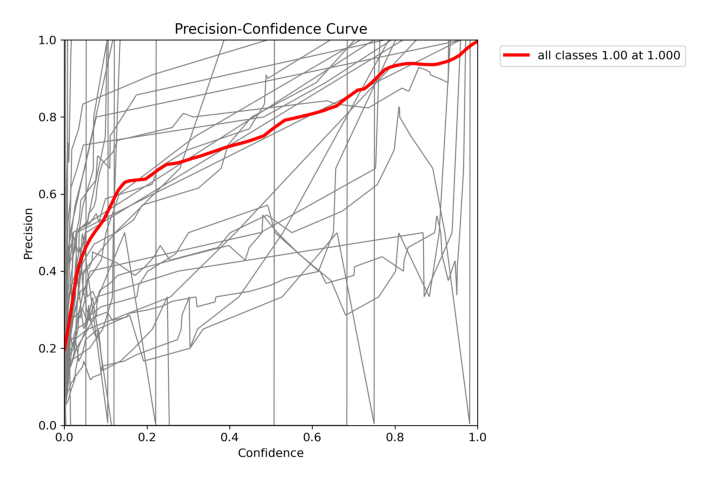

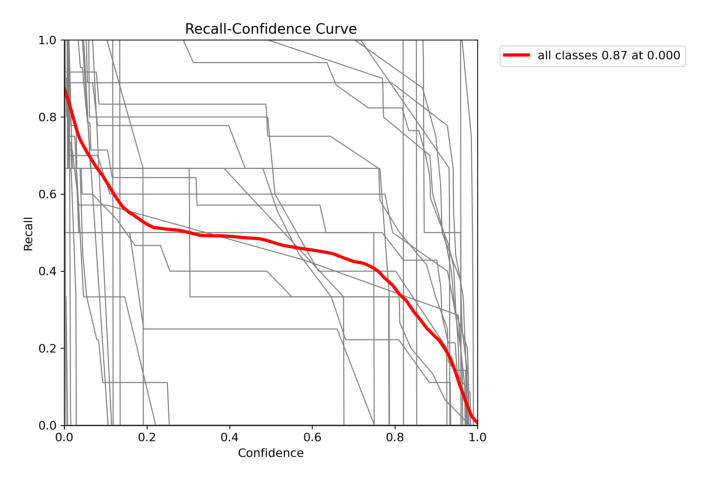

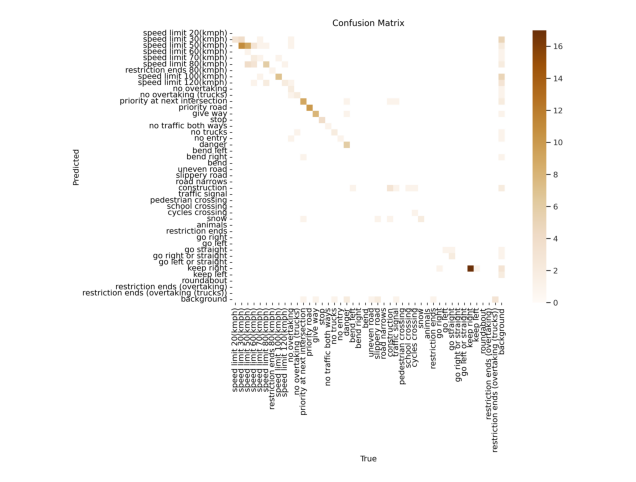

In [23]:
list_of_metrics = ["P_curve.png","R_curve.png","confusion_matrix.png"]

# Load the image
for i in list_of_metrics:
    image = cv2.imread(f'/kaggle/working/runs/detect/train/{i}')

    # Create a larger figure
    plt.figure(figsize=(10, 6))

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    # Show the plot
    plt.show()

In [24]:
import seaborn as sns

In [25]:
Result_model = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
Result_model.tail(10)

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
90,91,0.62804,0.46435,0.79305,0.65792,0.56157,0.64447,0.56472,0.50259,1.1007,0.77897,0.000023,0.000023,0.000023
91,92,0.52588,0.40980,0.79479,0.67683,0.56594,0.64075,0.56366,0.47157,1.1071,0.77532,0.000021,0.000021,0.000021
92,93,0.56239,0.38358,0.78679,0.65463,0.58307,0.66228,0.58210,0.47358,1.1135,0.77517,0.000019,0.000019,0.000019
93,94,0.52158,0.37203,0.78034,0.55280,0.63524,0.67223,0.59248,0.47935,1.1245,0.77516,0.000017,0.000017,0.000017
94,95,0.52098,0.37996,0.77903,0.50985,0.63779,0.65769,0.58573,0.47832,1.1512,0.77552,0.000015,0.000015,0.000015
95,96,0.52592,0.39369,0.78886,0.51905,0.65896,0.65189,0.58291,0.47034,1.1588,0.77506,0.000013,0.000013,0.000013
96,97,0.51644,0.36176,0.79553,0.51646,0.65518,0.67907,0.60605,0.46554,1.1389,0.77421,0.000011,0.000011,0.000011
97,98,0.52684,0.36986,0.79027,0.79443,0.47512,0.67623,0.60621,0.46389,1.1249,0.77334,0.000008,0.000008,0.000008
98,99,0.52843,0.37977,0.78796,0.79995,0.47817,0.67221,0.60492,0.46339,1.1168,0.77322,0.000006,0.000006,0.000006
99,100,0.50218,0.35385,0.79658,0.80818,0.47288,0.66875,0.60091,0.46253,1.1159,0.77295,0.000004,0.000004,0.000004


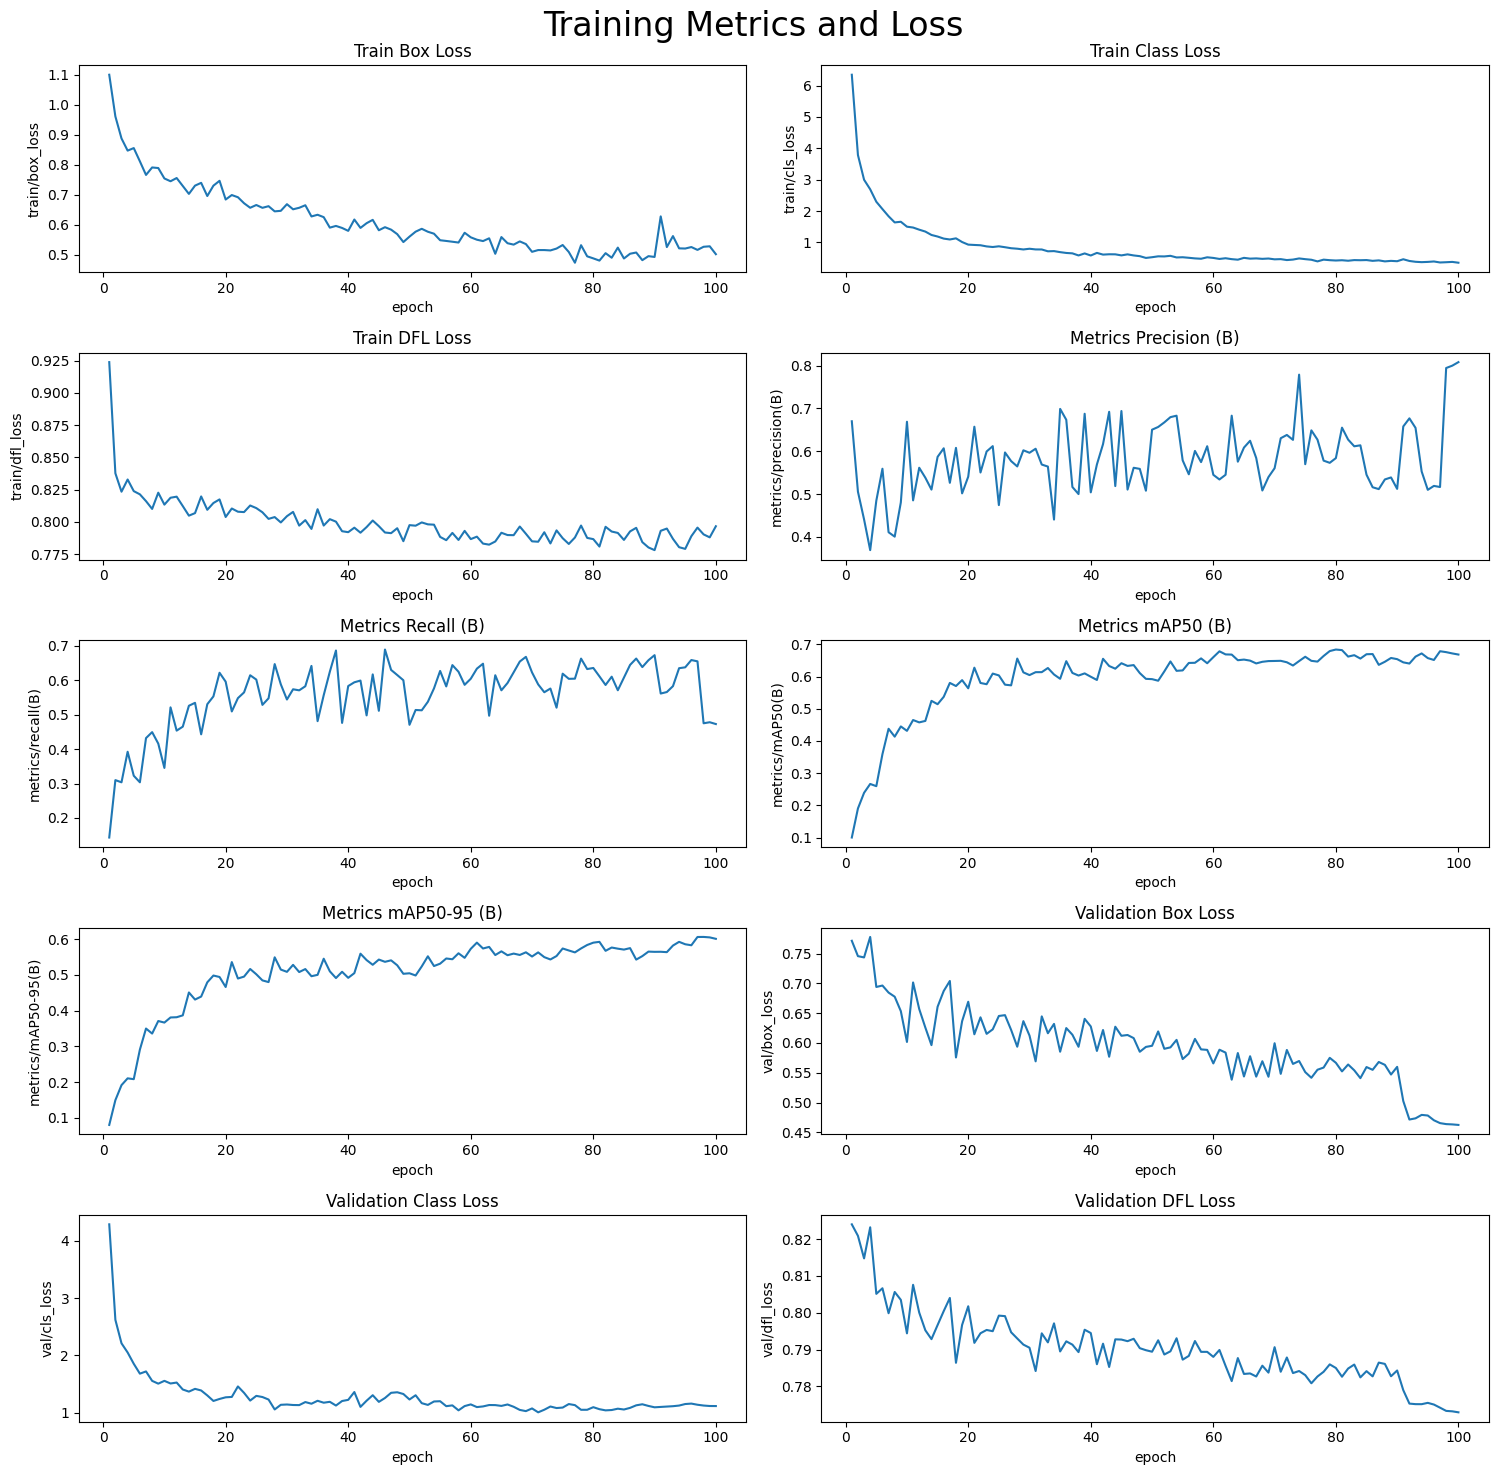

In [26]:
# Read the results.csv file as a pandas dataframe
df = Result_model.copy()
df.columns = df.columns.str.strip()

# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# Set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

In [27]:
path_best_weights="/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val()

print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 

Ultralytics YOLOv8.2.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 218 layers, 25864657 parameters, 0 gradients, 78.8 GFLOPs


val: Scanning /kaggle/working/datasets/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]


                   all        171        171      0.516      0.655      0.677       0.61
  speed limit 20(kmph)        171          3          1          0       0.25      0.225
  speed limit 30(kmph)        171         15      0.407      0.533      0.502      0.448
  speed limit 50(kmph)        171         14      0.288      0.714      0.489       0.44
  speed limit 60(kmph)        171          9      0.223      0.194      0.429      0.402
  speed limit 70(kmph)        171          4      0.252        0.5      0.299      0.295
  speed limit 80(kmph)        171          9      0.344      0.778      0.521      0.489
restriction ends 80(kmph)        171          1      0.522          1      0.995      0.995
 speed limit 100(kmph)        171          8      0.478          1      0.995      0.927
 speed limit 120(kmph)        171          3      0.132      0.667        0.5        0.5
         no overtaking        171          7      0.891      0.571      0.741      0.642
no overtaking (tru

In [28]:
with torch.no_grad():
    results=model.predict(source=test_dirs,conf=0.50,iou=0.75)


image 1/300 /kaggle/working/../input/german-traffic-sign-detection-dataset/gtsdb/test/00000.jpg: 384x640 (no detections), 88.9ms
image 2/300 /kaggle/working/../input/german-traffic-sign-detection-dataset/gtsdb/test/00001.jpg: 384x640 1 speed limit 120(kmph), 11.1ms
image 3/300 /kaggle/working/../input/german-traffic-sign-detection-dataset/gtsdb/test/00002.jpg: 384x640 (no detections), 11.2ms
image 4/300 /kaggle/working/../input/german-traffic-sign-detection-dataset/gtsdb/test/00003.jpg: 384x640 1 no overtaking (trucks), 11.2ms
image 5/300 /kaggle/working/../input/german-traffic-sign-detection-dataset/gtsdb/test/00004.jpg: 384x640 1 snow, 11.2ms
image 6/300 /kaggle/working/../input/german-traffic-sign-detection-dataset/gtsdb/test/00005.jpg: 384x640 1 speed limit 70(kmph), 1 speed limit 100(kmph), 11.2ms
image 7/300 /kaggle/working/../input/german-traffic-sign-detection-dataset/gtsdb/test/00006.jpg: 384x640 (no detections), 11.2ms
image 8/300 /kaggle/working/../input/german-traffic-sign

In [29]:
!mkdir "/kaggle/working/predictions"
prediction_dir="/kaggle/working/predictions"
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        class_name = result.boxes.cls.cpu().numpy().astype(int)
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for cls_name,score,box in zip(class_name,scores,boxes):
                text=f"{cls_name.astype(str)} {score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [30]:
def show_bbox(img,cls_names,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    cls_names = cls_names
    img=img.copy()
    for i,box in enumerate(boxes):
        cls_name = f"{id2label[cls_names[i]]}"
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,cls_name,(box[0]-50,y),cv2.FONT_HERSHEY_SIMPLEX,1.5,color,2)
        cv2.putText(img,score,(box[0]+50,y+50),cv2.FONT_HERSHEY_SIMPLEX,1,color,2)
    
    axis.imshow(img)
    axis.axis("off")

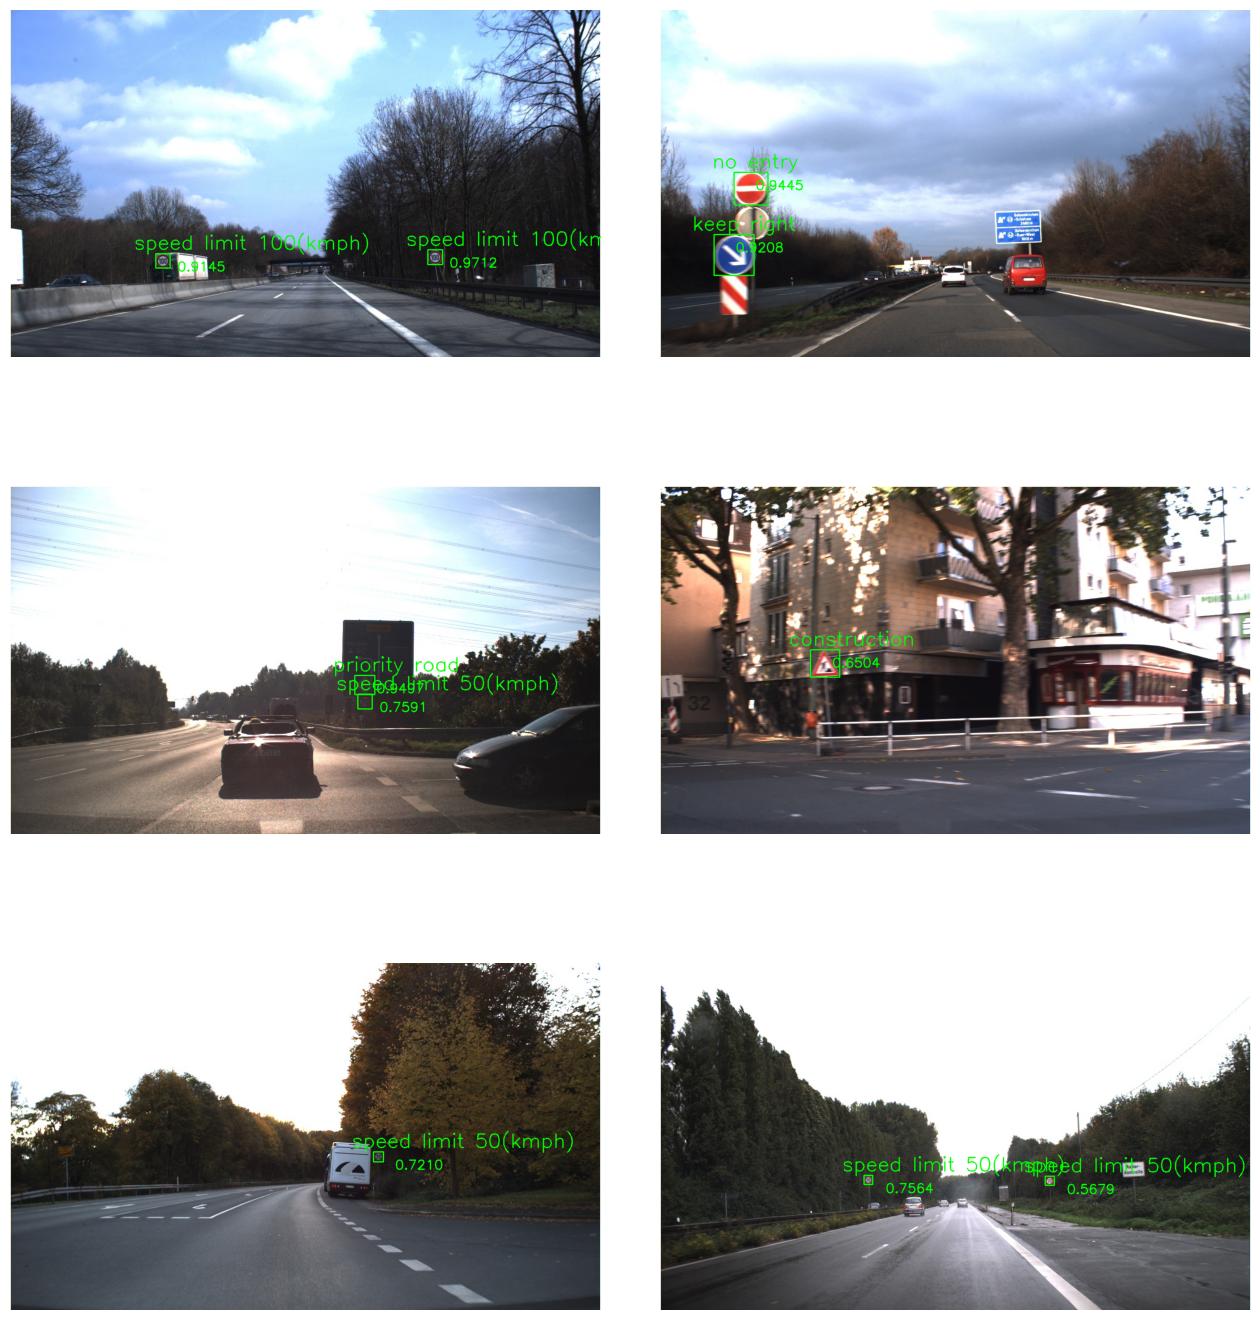

In [32]:
fig,axes=plt.subplots(3,2,figsize=(16,18))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,6)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_dirs,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    cls_name = label[:,0]
    scores=label[:,1]
    boxes=label[:,2:]
    show_bbox(img,cls_name,boxes,scores,axis=ax[i])